In [1]:
import numpy as np
import pandas as pd
import tldextract
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# Prepare data

In [3]:
#extract the website names from the links
links = df.article_link
domains = []
for link in links:
    ext = tldextract.extract(link)
    domains.append(ext.domain)

In [4]:
df['domain'] = domains

# Topic Modelling

In [7]:
#split headlines by websites
onion = df[df.domain.eq("theonion")]
onion_hl = onion.headline

huffpost = pd.concat([onion,df]).drop_duplicates(keep=False)
huffpost_hl = huffpost.headline

In [16]:
no_features = 3000

# NMF is able to use tf-idf
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
#tfidf = tfidf_vectorizer.fit_transform(documents)
#tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, ngram_range=(1,3), stop_words="english")

onion_hl_tf = tf_vectorizer.fit_transform(onion_hl)
tf_feature_names = tf_vectorizer.get_feature_names()

In [17]:
no_topics = 7

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda_onion = lda.fit_transform(onion_hl_tf)

In [18]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 25

display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
woman study just finds new like study finds report dad area plan sex death use phone face years don children end americans bad thought inside employees
Topic 1:
man new area area man family going world home bush way introduces night fucking friend away day president forced line releases movie know scientists actually pretty
Topic 2:
year old man time year old day just clinton report 000 friends 10 americans couple son human campaign news congress thinks national entire really money wants
Topic 3:
new child little announces party life man unveils parents long mom baby looking having used bar person america plans office wearing unveils new restaurant film half
Topic 4:
nation good state right gets obama finally game just video teen reveals real election class war speech list fuck group gay senate hoping law public
Topic 5:
trump house white school guy white house time report work john makes high like million employee takes dog room minutes food middle obama pope doing court
Topi

In [19]:
huff_hl_tf = tf_vectorizer.fit_transform(huffpost_hl)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA for huffpost
lda_huff = lda.fit_transform(huff_hl_tf)

display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
new trump obama clinton white hillary gay court hillary clinton family house campaign love men north new york york makes right democrats white house death holiday party ban
Topic 1:
watch says just video really school season home gets anti race day email high face live does food world team morning shows love talks jimmy
Topic 2:
year day life years gop old best sex president wedding letter year old plan needs end tax man 11 son says girl win marriage christmas super
Topic 3:
like stop making queer sanders photos fans media bernie twitter news violence james bernie sanders 000 support film time tv 2015 music social schumer takes 12
Topic 4:
women make real want health woman black war says care good college deal california business sexual 20 government reveals talk house children man john child
Topic 5:
trump donald donald trump world america state won election way dead look big speech shooting work stephen calls colbert presidential ready ways national stephen colbert open vote

# Word Cloud

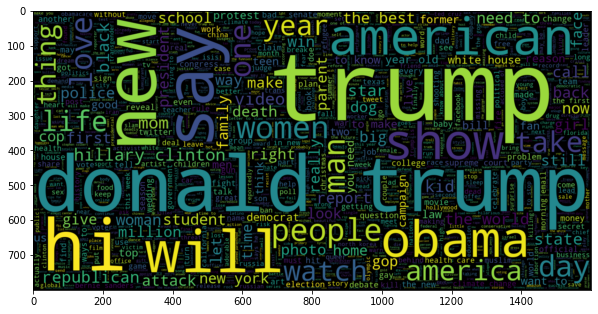

In [5]:
plt.figure(figsize = (10,10)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

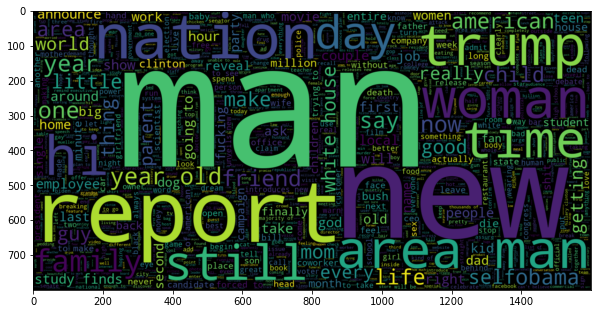

In [6]:
plt.figure(figsize = (10,10)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

# 